In [1]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import zscore
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, gaussian_filter1d

In [2]:
data_path='/media/maria/DATA1/Documents/data_for_suite2p/TX39/'
dt=1
spks= np.load(data_path+'spks.npy')
print('Shape of the data matrix, neurons by timepoints:',spks.shape)
iframe = np.load(data_path+'iframe.npy') # iframe[n] is the microscope frame for the image frame n
ivalid = iframe+dt<spks.shape[-1] # remove timepoints outside the valid time range
iframe = iframe[ivalid]
S = spks[:, iframe+dt]
print(S.shape)

Shape of the data matrix, neurons by timepoints: (18795, 30766)
(18795, 30560)


In [3]:
#zsc=zscore(S,axis=1)
#del S
del spks

In [4]:
#print(zsc)

In [5]:
import numpy as np
from sklearn.decomposition import PCA
pca = PCA(n_components=3000)
V=pca.fit_transform(S.T)
print(np.sum(pca.explained_variance_ratio_))
print(V.shape)

0.86673564
(30560, 3000)


In [6]:
def train_test_split(NT):
        nsegs = 20
        nt=NT
        nlen  = nt/nsegs
        ninds = np.linspace(0,nt-nlen,nsegs).astype(int)
        itest = (ninds[:,np.newaxis] + np.arange(0,nlen*0.25,1,int)).flatten()
        itrain = np.ones(nt, np.bool)
        itrain[itest] = 0
        return itrain, itest

In [11]:
NT = S.shape[1]
itrain,itest=train_test_split(NT)
print(itrain)

[False False False ...  True  True  True]


In [13]:
proc = np.load(data_path+'cam1_TX39_2019_05_31_1_proc_resampled.npy', allow_pickle=True).item()
motSVD = proc['motSVD'][:,iframe+dt]
motSVD -= motSVD.mean(axis=1)[:,np.newaxis]
beh=motSVD[:,:]
covM = np.matmul(beh[:,itrain], beh[:,itrain].T)
lam = 1e5 # regularizer
covM += lam*np.eye(beh.shape[0])
A = np.linalg.solve(covM, np.matmul(beh[:,itrain], V.T[:,itrain].T))
Vpred = np.matmul(A.T, beh[:,itest])
beh_corr_lst=[]
nr_of_components=3000
for j in range(0,nr_of_components):
    beh_corr_lst.append(np.corrcoef(Vpred[j,:],V.T[j,itest])[0,1])

[0.7924472089045497, 0.46238762538923, 0.5766752204461887, 0.3471716945041861, 0.13161622778184967, 0.09947604387074667, 0.30095923251690493, 0.470035796557372, 0.14896057086269135, 0.14367422600351185, 0.14036118117084428, 0.1292985891720171, 0.05534556502911843, 0.11379033991119232, 0.05951893677524747, 0.08876009777073766, 0.15550085004354586, 0.06102325992008134, 0.04941983273681484, 0.042358128640481885, 0.07806718155483504, 0.13173550931388264, 0.06962557325514385, 0.12814665670716444, 0.08239949240038122, 0.13152744328734453, 0.10083325873795107, 0.13377633612320583, 0.05781611570715538, 0.028358433491219272, 0.04885714974976661, 0.14338761237649894, 0.14474249056475252, 0.04741255534022395, 0.03176224723946511, 0.03971985559387731, 0.05050628257285486, 0.09748667572340736, 0.055668175040014686, 0.14492216627477744, 0.06649969221009691, 0.033329808153114114, 0.08298949649999071, 0.04595727678366662, 0.0800499692193249, 0.030883220614658133, 0.03217371941498353, 0.025924172718161

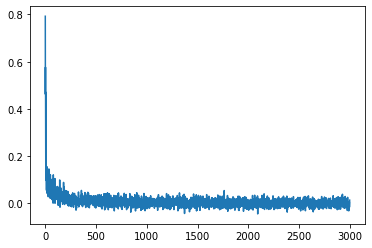

In [15]:
plt.plot(beh_corr_lst)
print(beh_corr_lst)


In [16]:
stat = np.load((data_path+'stat.npy'), allow_pickle=True) # these are the per-neuron stats returned by suite2p
# these are the neurons' 2D coordinates
ypos = np.array([stat[n]['med'][0] for n in range(len(stat))]) 
# (notice the python list comprehension [X(n) for n in range(N)])
xpos = np.array([stat[n]['med'][1] for n in range(len(stat))]) 

In [17]:
print(pca.components_.shape)

(3000, 18795)


In [ ]:
plt.figure(figsize=(30,30))
for j in range(40):
    comp= pca.components_[j,:]
    comp= comp/np.max(np.abs(comp))
    lam = np.abs(comp)    
    ax=plt.subplot(8,5,1+j)
    plt.scatter(xpos, -ypos, s = 50 * lam, c = comp, cmap='bwr', alpha = .5)
    plt.title('Ens ind: '+str(j)+' Behcorr: '+str(beh_corr_lst[j])[0:4])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    #plt.colorbar()